In [ ]:
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/17/1c/ccdd103cfcc9435a18819856fbbe0c20b8fa60bfc3343580de4be13f0668/scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/ea/c2/5ecadc5fcccefaece775feadcd795060adf5c3b29a883bff0e678cfe89af/scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata
  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

In [72]:
# Load the data
df = pd.read_csv("nba_2019-20_data.csv")

# Summary statistics
print("Summary Statistics:\n", df.describe())

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Summary Statistics:
             GAME_ID       TEAM_ID   OPP_TEAM_ID   PLUS_MINUS           WL  \
count  1.043000e+03  1.043000e+03  1.043000e+03  1043.000000  1043.000000   
mean   2.190056e+07  1.610613e+09  1.610613e+09     2.113135     0.550336   
std    3.419944e+02  8.640710e+00  8.547946e+00    14.118658     0.497699   
min    2.190002e+07  1.610613e+09  1.610613e+09   -41.000000     0.000000   
25%    2.190028e+07  1.610613e+09  1.610613e+09    -8.000000     0.000000   
50%    2.190054e+07  1.610613e+09  1.610613e+09     3.000000     1.000000   
75%    2.190080e+07  1.610613e+09  1.610613e+09    11.000000     1.000000   
max    2.190132e+07  1.610613e+09  1.610613e+09    49.000000     1.000000   

           P_W_PCT       PAST_5   PAST_5_PTS        P_W-L  P_W_PCT_OPP  \
count  1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean      0.499444     0.491083   111.379642     0.345158     0.512643   
std       0.198053     0.263513     6.779780    13.709970     0

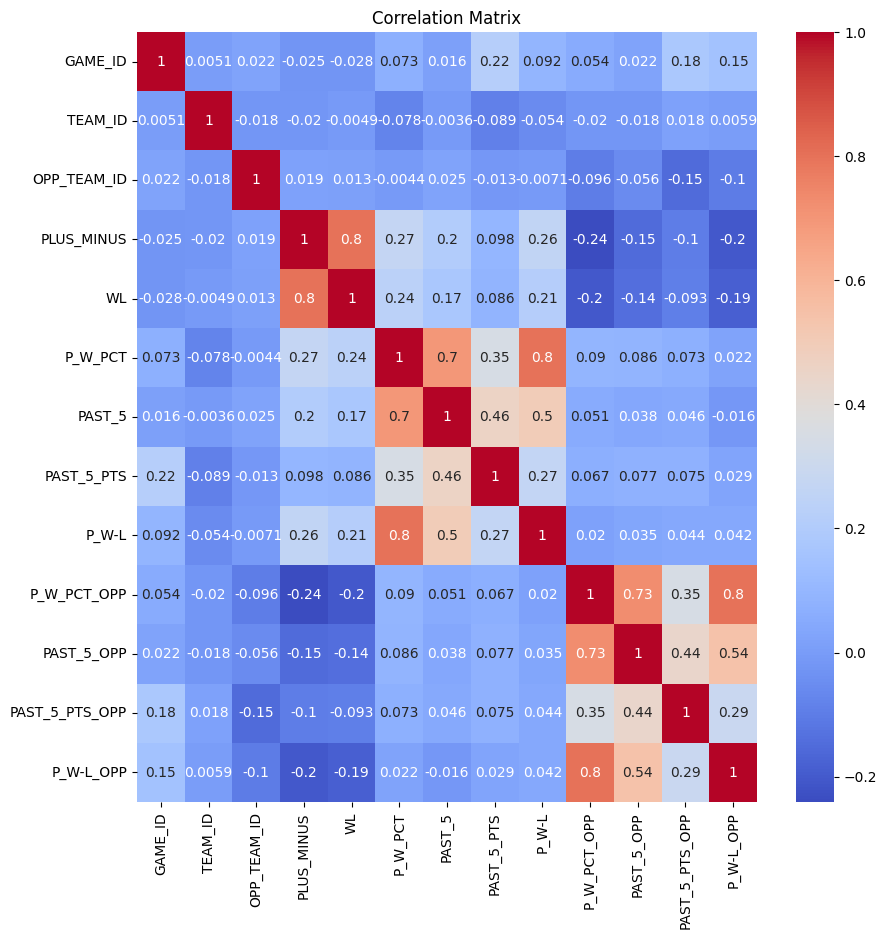

In [73]:
# for all numerical columns in the dataset do correlation analysis
# choose numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
# correlation analysis
correlation = df[numerical_columns].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

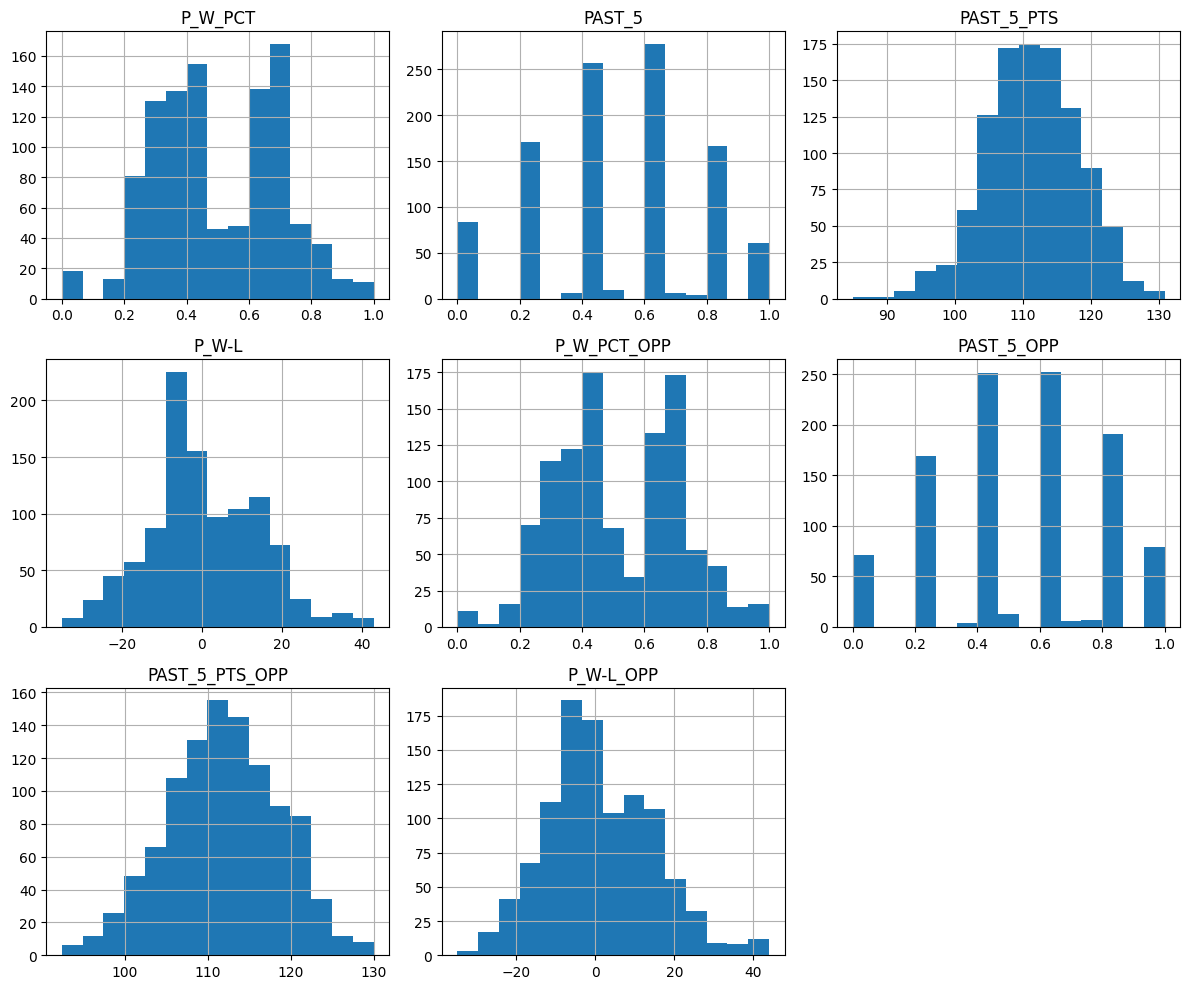

In [45]:
# Visualize the distributions of numeric features
num_features = [
    "P_W_PCT", "PAST_5", "PAST_5_PTS", "P_W-L", 
    "P_W_PCT_OPP", "PAST_5_OPP", "PAST_5_PTS_OPP", "P_W-L_OPP"
]
df[num_features].hist(bins=15, figsize=(12, 10))
plt.tight_layout()
plt.show()

None of the features are too skewed, so that's good. We won't need log transformations.

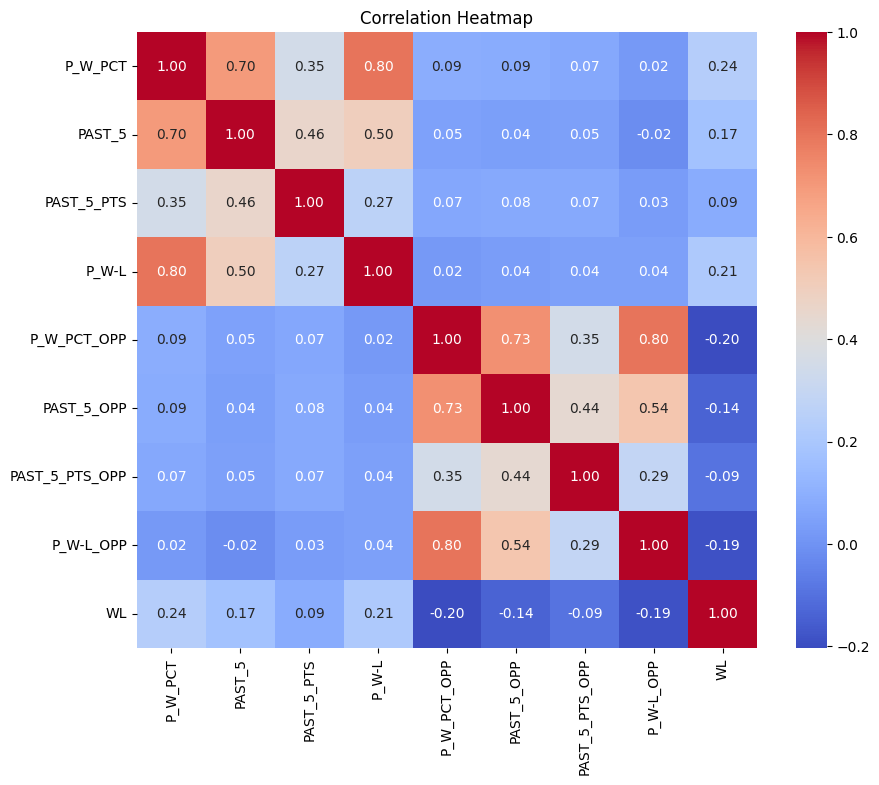

In [46]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_features + ["WL"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Highly correlated features might be an issue, codeblock below might be able to address that but it has to be well thought out. As of now, Im continuing without dropping correlated features or creating interaction terms using them.

In [47]:
# # THIS IS CODE BLOCK TO DO SOMETHING ABOUT HIGHLY CORRELATED FEATURES (MIGHT DEGRADE PERFORMANCE OR NOT, we'll see)

# # Add interaction terms
# df['P_WL_DIFF'] = df['P_W-L'] - df['P_W-L_OPP']  # Difference in win-loss between teams
# df['PAST_5_RATIO'] = df['PAST_5'] / (df['PAST_5_OPP'] + 1e-5)  # Prevent division by zero

# # Create new features by combining highly correlated ones
# df['P_W_PCT_PAST_5_RATIO'] = df['P_W_PCT'] / (df['PAST_5'] + 1e-5)  # Prevent division by zero
# df['P_W_L_PAST_5_DIFF'] = df['P_W-L'] - df['P_W-L_OPP']  # Difference in win-loss between teams

# df['P_W_PCT_DIFF'] = df['P_W_PCT'] - df['P_W_PCT_OPP']  # Difference in win percentage
# df['PAST_5_RATIO'] = df['PAST_5'] / (df['PAST_5_OPP'] + 1e-5)  # Ratio of past 5 games performance
# df['P_WL_DIFF'] = df['P_W-L'] - df['P_W-L_OPP']  # Difference in win-loss between teams



# # Drop original features if necessary
# df = df.drop(['P_W_PCT', 'PAST_5', 'P_W_PCT_OPP', 'P_W-L_OPP', 'PAST_5_OPP'], axis=1)

In [48]:
# # Generate the correlation matrix for numerical columns only
# numeric_data = df.select_dtypes(include=['number'])

# correlation_matrix = numeric_data.corr()

# # Plot the correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title("Correlation Heatmap")
# plt.show()

In [59]:
# Take care of categorical columns

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to categorical columns
df['TEAM_ABBREVIATION_ENCODED'] = label_encoder.fit_transform(df['TEAM_ABBREVIATION'])
df['OPP_TEAM_ABBREVIATION_ENCODED'] = label_encoder.fit_transform(df['OPP_TEAM_ABBREVIATION'])

In [85]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [87]:
# Separate features and target variable (also drop unnecessary columns)
X = df.drop(['GAME_ID', 'GAME_DATE', 'TEAM_ID', 'OPP_TEAM_ID', 'TEAM_ABBREVIATION', 'OPP_TEAM_ABBREVIATION', 'WL', 'PLUS_MINUS'], axis=1)
y = df['WL']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling for models that require it (Logistic Regression and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training and evaluation function
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics (for regression)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    # For classification tasks, add these metrics (if applicable)
    if len(set(y_test)) <= 2:  # Assuming binary classification if only two unique values in y
        print(classification_report(y_test, y_pred.round()))  # For classification evaluation

    return mse, r2

# Define hyperparameter grids for each model
param_grids = {
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]  # Replaced 'auto' with 'sqrt' and 'log2'
    },
    "Logistic Regression": {
        'C': [0.1, 1, 10],  # Regularization strength
        'penalty': ['l1', 'l2'],  # Regularization type
        'solver': ['liblinear']  # Solver for small datasets
    }
}


# Initialize models
models = {
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# Compare each model's performance using GridSearchCV for hyperparameter tuning
results = {}
for name, model in models.items():
    print(f"\nTraining and evaluating {name} model:")
    
    # Define the parameter grid for this model
    param_grid = param_grids[name]
    
    # Perform GridSearchCV to find the best parameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled if name in ['Logistic Regression', 'SVM'] else X_train, y_train)
    
    # Best model from grid search
    best_model = grid_search.best_estimator_
    print(f"Best Parameters for {name}: {grid_search.best_params_}")
    
    # Train and evaluate the best model
    mse, r2 = train_and_evaluate(best_model, X_train_scaled if name in ['Logistic Regression', 'SVM'] else X_train, 
                                  X_test_scaled if name in ['Logistic Regression', 'SVM'] else X_test, 
                                  y_train, y_test)
    
    # For classification tasks, you can also calculate accuracy
    y_pred = best_model.predict(X_test_scaled if name in ['Logistic Regression', 'SVM'] else X_test)
    acc_score = accuracy_score(y_test, y_pred.round())  # Changed the variable name to avoid conflict
    results[name] = {"MSE": mse, "R-squared": r2, "Accuracy": acc_score}

# Display results summary
print("\nModel Comparison Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['MSE']:.4f}, R-squared = {metrics['R-squared']:.4f}, Accuracy = {metrics['Accuracy']:.4f}")


Training and evaluating XGBoost model:
Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Model: XGBRegressor
Mean Squared Error: 0.2236
R-squared: 0.1030
              precision    recall  f1-score   support

           0       0.71      0.53      0.60        99
           1       0.65      0.81      0.72       110

    accuracy                           0.67       209
   macro avg       0.68      0.67      0.66       209
weighted avg       0.68      0.67      0.67       209


Training and evaluating SVM model:
Best Parameters for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Model: SVR
Mean Squared Error: 0.2239
R-squared: 0.1020
              precision    recall  f1-score   support

           0       0.70      0.60      0.64        99
           1       0.68      0.77      0.72       110

    accuracy                           0.69       209
   macro avg       0.69      0.68      0.68       2

In [69]:
X_train.head()

,PLUS_MINUS,P_W_PCT,PAST_5,PAST_5_PTS,P_W-L,P_W_PCT_OPP,PAST_5_OPP,PAST_5_PTS_OPP,P_W-L_OPP,TEAM_ABBREVIATION_ENCODED,OPP_TEAM_ABBREVIATION_ENCODED
544,-1,0.639,0.4,111.4,10.0,0.694,0.6,117.0,14.0,6,7
256,-9,0.278,0.2,104.2,-8.0,0.833,1.0,121.8,12.0,5,16
350,-8,0.391,0.6,109.2,-5.0,0.208,0.0,94.6,-14.0,26,5
60,10,0.600,0.6,120.0,1.0,0.800,0.8,114.6,3.0,16,27
928,-5,0.444,0.8,114.8,-7.0,0.710,0.4,111.0,26.0,25,27


In [68]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: WL, dtype: int64